In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib 
import os

C:\Users\Luis\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
os.chdir('C:/Users/Luis/Box/R15 Sensor Preprocessing and Analysis/JPCS Special Issue') #set directory
raw = pd.read_csv('Full_Summary_Features_clean_2-24-2024.csv') #filtered summary data from madison

In [3]:
for col in raw.columns: 
    print(col) #i want to see all the columns so i can specifically pick the features i actually want
    #we are going to make a dataset containing just restrict alongside predictors aka physio
    #then we are going to make another dataset containing just urge to restrict alongside physio
    #we don't want to include any other EMA in our train/test data for each analysis

Unnamed..0
Time
HR_Mean
HR_Minimum
HR_Maximum
HR_Stdev
HR_RMS
HR_MAD
HR_MAV
HR_Median
HR_P25
HR_P75
EDA_Mean
EDA_Minimum
EDA_Maximum
EDA_Stdev
EDA_RMS
EDA_MAD
EDA_MAV
EDA_Median
EDA_P25
EDA_P75
TEMP_Mean
TEMP_Minimum
TEMP_Maximum
TEMP_Stdev
TEMP_RMS
TEMP_MAD
TEMP_MAV
TEMP_Median
TEMP_P25
TEMP_P75
meanCenteredEDA_Mean
meanCenteredEDA_Minimum
meanCenteredEDA_Maximum
meanCenteredEDA_Stdev
meanCenteredEDA_RMS
meanCenteredEDA_MAD
meanCenteredEDA_MAV
meanCenteredEDA_Median
meanCenteredEDA_P25
meanCenteredEDA_P75
meanCenteredHR_Mean
meanCenteredHR_Minimum
meanCenteredHR_Maximum
meanCenteredHR_Stdev
meanCenteredHR_RMS
meanCenteredHR_MAD
meanCenteredHR_MAV
meanCenteredHR_Median
meanCenteredHR_P25
meanCenteredHR_P75
meanCenteredTEMP_Mean
meanCenteredTEMP_Minimum
meanCenteredTEMP_Maximum
meanCenteredTEMP_Stdev
meanCenteredTEMP_RMS
meanCenteredTEMP_MAD
meanCenteredTEMP_MAV
meanCenteredTEMP_Median
meanCenteredTEMP_P25
meanCenteredTEMP_P75
ethica_time
lag
tdif
cumsumT
ethica_time_utc
dayvar
beepvar


In [4]:
#random seed. I picked 6 because I like 6 and i always pick 6. this is so we get the same results every time
np.random.seed(6)

In [5]:
#creating the dataset for predicting urge_restrict from physio alone
urgeData = raw.filter(['meanCenteredEDA_Mean', 'meanCenteredEDA_Minimum', 'meanCenteredEDA_Maximum', 'meanCenteredEDA_Stdev', 
                       'meanCenteredEDA_RMS', 'meanCenteredEDA_MAD', 'meanCenteredEDA_MAV', 'meanCenteredEDA_Median', 
                       'meanCenteredEDA_P25', 'meanCenteredEDA_P75', 'meanCenteredHR_Mean', 'meanCenteredHR_Minimum', 
                       'meanCenteredHR_Maximum', 'meanCenteredHR_Stdev', 'meanCenteredHR_RMS', 'meanCenteredHR_MAD', 
                       'meanCenteredHR_MAV', 'meanCenteredHR_Median', 'meanCenteredHR_P25', 'meanCenteredHR_P75', 
                       'meanCenteredTEMP_Mean', 'meanCenteredTEMP_Minimum', 'meanCenteredTEMP_Maximum', 'meanCenteredTEMP_Stdev', 
                       'meanCenteredTEMP_RMS', 'meanCenteredTEMP_MAD', 'meanCenteredTEMP_MAV', 'meanCenteredTEMP_Median', 
                       'meanCenteredTEMP_P25', 'meanCenteredTEMP_P75', 'urge_restrict'])




In [6]:
#creating the dataset for predicting restrict from physio alone
restrictData = raw.filter(['meanCenteredEDA_Mean', 'meanCenteredEDA_Minimum', 'meanCenteredEDA_Maximum', 'meanCenteredEDA_Stdev', 
                       'meanCenteredEDA_RMS', 'meanCenteredEDA_MAD', 'meanCenteredEDA_MAV', 'meanCenteredEDA_Median', 
                       'meanCenteredEDA_P25', 'meanCenteredEDA_P75', 'meanCenteredHR_Mean', 'meanCenteredHR_Minimum', 
                       'meanCenteredHR_Maximum', 'meanCenteredHR_Stdev', 'meanCenteredHR_RMS', 'meanCenteredHR_MAD', 
                       'meanCenteredHR_MAV', 'meanCenteredHR_Median', 'meanCenteredHR_P25', 'meanCenteredHR_P75', 
                       'meanCenteredTEMP_Mean', 'meanCenteredTEMP_Minimum', 'meanCenteredTEMP_Maximum', 'meanCenteredTEMP_Stdev', 
                       'meanCenteredTEMP_RMS', 'meanCenteredTEMP_MAD', 'meanCenteredTEMP_MAV', 'meanCenteredTEMP_Median', 
                       'meanCenteredTEMP_P25', 'meanCenteredTEMP_P75', 'restrict'])



In [7]:
urgeData.dropna(subset=["urge_restrict"], inplace = True) #remove any cases where EMA is missing
np.any(np.isnan(urgeData['urge_restrict'])) #check that NAs exist - if false, we are good

restrictData.dropna(subset=["restrict"], inplace = True) #remove any cases where EMA is missing
np.any(np.isnan(restrictData['restrict'])) #check that NAs exist - if false, we are good

False

In [8]:
#we want to randomly assort the rows in these dataframes now since they're clustered by participant
restrictDataShuffled = restrictData.sample(frac = 1) #shuffle restriction dataset
urgeDataShuffled = urgeData.sample(frac = 1) #shuffle urge dataset

In [9]:
#now what i want to do is reserve a portion of the data to test after the fact - the remaining data we'll do k-fold cross validation
#we're going to split the data as follows: 
#80% of the data is going to be the train/test data for the model
#the remaining 20% will be held and we will use the trained/tested model to see how closely it predicts the 20% holdover set

from sklearn.model_selection import train_test_split

urgeX = urgeDataShuffled.drop(columns = {'urge_restrict'}) #drop urge_restrict from dataframe for the splitting
urgey = urgeDataShuffled.filter(['urge_restrict']) #make a dataframe containing only urge_restrict variable

restX = restrictDataShuffled.drop(columns = {'restrict'})
resty = restrictDataShuffled.filter(['restrict'])

In [10]:
urgeX_train, urgeX_test, urgey_train, urgey_test = train_test_split(urgeX, urgey, random_state=6,test_size=0.20) 
restX_train, restX_test, resty_train, resty_test = train_test_split(restX, resty, random_state=6,test_size=0.20) 
#we're sticking with 6 for random_state
#the test sets are what we are going to validate our models on later

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet

#we're going to start exclusively with the urge data for now, we'll circle back to the restrict data later 

urgeMod = ElasticNet() #we're starting with default parameters - alpha=1.0, l1_ratio=0.5
urgecv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=6) #i still like 6, we're doing a 10-fold cross-validation repeating 3 times


In [12]:
from sklearn.model_selection import cross_validate
from numpy import mean
from numpy import std
from numpy import absolute

def cross_validation(model, _X, _y, _cv):
    _scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
    results = cross_validate(estimator = model, X = _X, y = _y, cv = _cv, scoring = _scoring, return_train_score = True)
    #print(results)
    return {#"MAE scores": absolute(results['train_neg_mean_absolute_error']),
            "Mean MAE": absolute(results['train_neg_mean_absolute_error']).mean(),
            #"MSE scores": absolute(results['train_neg_mean_squared_error']),
            "Mean MSE": absolute(results['train_neg_mean_squared_error']).mean(),
            #"R^2 scores": absolute(results['train_r2']),
            "Mean R^2": absolute(results['train_r2']).mean()} #make a function for all performance metrics

In [13]:
urgecv_result = cross_validation(urgeMod, urgeX_train, urgey_train, urgecv)
print(urgecv_result) #well we're on average ~26.5 points off of predicting urge to restrict

{'Mean MAE': 26.47874485549623, 'Mean MSE': 946.6085695917993, 'Mean R^2': 0.03777392875523218}


In [14]:
#might as well try restrict now 

restMod = ElasticNet()
restcv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=6)
restcv_result = cross_validation(restMod, restX_train, resty_train, restcv)
print(restcv_result) #we're on average ~29.5 points off of predicting restriction

{'Mean MAE': 29.522097506654028, 'Mean MSE': 1101.295243658522, 'Mean R^2': 0.04689058977877744}


In [17]:
diag

,record_id_73f3b8,currentdx1_ade7bc,currentdx2_f885e2,diagnostic_status
0,Mackenzie Practice w Cheri,NaN,NaN,NaN
1,PR001,2.0,3.0,3.0
2,PR003,1.0,2.0,3.0
3,PR002,4.0,6.0,NaN
4,PR006,4.0,8.0,NaN
...,...,...,...,...
179,PR223,1.0,1.0,3.0
180,PR222,4.0,6.0,3.0
181,PR225,4.0,7.0,2.0
182,PR224,4.0,6.0,3.0


In [15]:
#we're gonna try with diagnoses now 

diag = pd.read_csv('ScreeningsR15-EDDiagnosticsSummary_DATA_2024-02-25_1408.csv') #dataframe containing diagnoses by ID
diag["PR"] = diag['record_id_73f3b8'] #making a column to match IDs
diag = diag.filter(['PR', 'currentdx1_ade7bc']) #i want to only merge the current general diagnoses and keep the ID variable
diagRaw = diag.merge(raw, how = 'inner', on = 'PR') #we made it 

diagRaw.head()

In [32]:
#coding values: 1 = AN, 2 = BN, 3 = BED, 4 = OSFED... there should  be no BED cases. 
#we will look at AN and BN specifically for now

bnmask = diagRaw['currentdx1_ade7bc'].values == 2
bn = diagRaw.loc[bnmask]
bn

,PR,currentdx1_ade7bc,Unnamed..0,Time,HR_Mean,HR_Minimum,HR_Maximum,HR_Stdev,HR_RMS,HR_MAD,...,socialanx_meanCentered,socialanx_medCentered,sens_body_meanCentered,sens_body_medCentered,ridthoughts_meanCentered,ridthoughts_medCentered,memories_meanCentered,memories_medCentered,chewspit_meanCentered,chewspit_medCentered
116,PR008,2.0,66,10/13/2020 14:02,80.923294,65.93,99.58,11.199806,81.694327,10.323301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,PR008,2.0,65,10/13/2020 15:30,85.171587,57.12,108.05,12.915180,86.144829,10.067898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,PR008,2.0,64,10/13/2020 20:47,101.010100,76.67,123.77,10.436887,101.547642,8.107601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,PR008,2.0,63,10/13/2020 23:02,75.283607,56.62,95.87,10.608913,76.027124,8.953679,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,PR008,2.0,62,10/14/2020 13:06,90.949538,75.68,111.62,10.847532,91.593877,9.519926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410,PR096,2.0,2,03:00.0,85.603240,70.62,104.03,8.539360,86.027932,6.751986,...,-2.516854,1.0,-3.146067,0.0,5.460674,8.0,-3.505618,0.0,-0.089888,0.0
1411,PR096,2.0,3,01:00.0,84.698759,70.62,104.03,8.772820,85.151689,7.092705,...,-2.516854,1.0,-3.146067,0.0,5.460674,8.0,-3.505618,0.0,-0.089888,0.0
1412,PR096,2.0,5,18:00.0,89.046593,67.85,108.37,9.849795,89.589474,8.001882,...,-2.516854,1.0,-3.146067,0.0,5.460674,8.0,-3.505618,0.0,-0.089888,0.0
1413,PR096,2.0,1,21:00.0,79.500428,66.50,90.30,7.650826,79.867096,6.488732,...,0.483146,4.0,44.853933,48.0,-2.539326,0.0,-2.505618,1.0,-0.089888,0.0


In [33]:
anmask = diagRaw['currentdx1_ade7bc'].values == 1
an = diagRaw.loc[anmask]
an

,PR,currentdx1_ade7bc,Unnamed..0,Time,HR_Mean,HR_Minimum,HR_Maximum,HR_Stdev,HR_RMS,HR_MAD,...,socialanx_meanCentered,socialanx_medCentered,sens_body_meanCentered,sens_body_medCentered,ridthoughts_meanCentered,ridthoughts_medCentered,memories_meanCentered,memories_medCentered,chewspit_meanCentered,chewspit_medCentered
0,PR003,1.0,117,58:00.0,93.129563,66.83,120.20,14.947826,94.321047,13.171499,...,9.483051,21.0,0.279661,-1.0,13.211864,3.0,10.110169,-0.5,0.000000,0.0
1,PR003,1.0,116,28:00.0,67.698626,56.77,85.90,6.844791,68.043630,5.718079,...,10.483051,22.0,3.279661,2.0,7.211864,-3.0,-58.889831,-69.5,0.000000,0.0
2,PR003,1.0,115,56:00.0,70.553065,55.93,93.38,9.837114,71.235269,7.708571,...,-11.516949,0.0,-1.720339,-3.0,12.211864,2.0,-58.889831,-69.5,0.000000,0.0
3,PR003,1.0,114,56:00.0,90.937768,57.98,149.50,25.878040,94.546664,23.029055,...,-11.516949,0.0,-2.720339,-4.0,3.211864,-7.0,9.110169,-1.5,0.000000,0.0
4,PR003,1.0,113,25:00.0,74.612836,57.92,93.05,10.477028,75.344527,8.849632,...,-11.516949,0.0,1.279661,0.0,17.211864,7.0,9.110169,-1.5,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1765,PR126,1.0,4,3/6/2022 20:55,90.805802,70.77,125.52,15.473832,92.114241,13.182557,...,-4.718750,-6.0,-2.084211,-1.0,-13.905263,0.0,-0.635417,0.0,-0.010417,0.0
1766,PR126,1.0,3,3/7/2022 0:47,83.927884,70.80,108.52,9.284703,84.439680,7.116636,...,9.281250,8.0,-1.084211,0.0,-13.905263,0.0,-0.635417,0.0,-0.010417,0.0
1767,PR126,1.0,2,3/7/2022 15:52,73.613249,60.22,119.67,17.032756,75.557292,13.276176,...,-13.718750,-15.0,7.915789,9.0,-13.905263,0.0,-0.635417,0.0,-0.010417,0.0
1768,PR126,1.0,1,3/7/2022 19:54,90.784519,60.23,137.07,19.107132,92.772622,15.632756,...,42.281250,41.0,27.915789,29.0,-13.905263,0.0,-0.635417,0.0,-0.010417,0.0


In [43]:
bnUrgeData = bn.filter(['meanCenteredEDA_Mean', 'meanCenteredEDA_Minimum', 'meanCenteredEDA_Maximum', 'meanCenteredEDA_Stdev', 
                       'meanCenteredEDA_RMS', 'meanCenteredEDA_MAD', 'meanCenteredEDA_MAV', 'meanCenteredEDA_Median', 
                       'meanCenteredEDA_P25', 'meanCenteredEDA_P75', 'meanCenteredHR_Mean', 'meanCenteredHR_Minimum', 
                       'meanCenteredHR_Maximum', 'meanCenteredHR_Stdev', 'meanCenteredHR_RMS', 'meanCenteredHR_MAD', 
                       'meanCenteredHR_MAV', 'meanCenteredHR_Median', 'meanCenteredHR_P25', 'meanCenteredHR_P75', 
                       'meanCenteredTEMP_Mean', 'meanCenteredTEMP_Minimum', 'meanCenteredTEMP_Maximum', 'meanCenteredTEMP_Stdev', 
                       'meanCenteredTEMP_RMS', 'meanCenteredTEMP_MAD', 'meanCenteredTEMP_MAV', 'meanCenteredTEMP_Median', 
                       'meanCenteredTEMP_P25', 'meanCenteredTEMP_P75', 'urge_restrict'])

bnRestrictData = bn.filter(['meanCenteredEDA_Mean', 'meanCenteredEDA_Minimum', 'meanCenteredEDA_Maximum', 'meanCenteredEDA_Stdev', 
                       'meanCenteredEDA_RMS', 'meanCenteredEDA_MAD', 'meanCenteredEDA_MAV', 'meanCenteredEDA_Median', 
                       'meanCenteredEDA_P25', 'meanCenteredEDA_P75', 'meanCenteredHR_Mean', 'meanCenteredHR_Minimum', 
                       'meanCenteredHR_Maximum', 'meanCenteredHR_Stdev', 'meanCenteredHR_RMS', 'meanCenteredHR_MAD', 
                       'meanCenteredHR_MAV', 'meanCenteredHR_Median', 'meanCenteredHR_P25', 'meanCenteredHR_P75', 
                       'meanCenteredTEMP_Mean', 'meanCenteredTEMP_Minimum', 'meanCenteredTEMP_Maximum', 'meanCenteredTEMP_Stdev', 
                       'meanCenteredTEMP_RMS', 'meanCenteredTEMP_MAD', 'meanCenteredTEMP_MAV', 'meanCenteredTEMP_Median', 
                       'meanCenteredTEMP_P25', 'meanCenteredTEMP_P75', 'restrict'])


In [44]:
bnUrgeData.dropna(subset=["urge_restrict"], inplace = True) #remove any cases where EMA is missing
np.any(np.isnan(bnUrgeData['urge_restrict'])) #check that NAs exist - if false, we are good

bnRestrictData.dropna(subset=["restrict"], inplace = True) #remove any cases where EMA is missing
np.any(np.isnan(bnRestrictData['restrict']))#check that NAs exist - if false, we are good

False

In [55]:
bnUrgeDataShuffled = bnUrgeData.sample(frac = 1) #shuffling BN data
bnRestrictDataShuffled = bnRestrictData.sample(frac = 1)

bnUrgeX = bnUrgeDataShuffled.drop(columns = {'urge_restrict'}) #drop urge_restrict from dataframe for the splitting
bnUrgey = bnUrgeDataShuffled.filter(['urge_restrict']) #make a dataframe containing only urge_restrict variable

bnRestX = bnRestrictDataShuffled.drop(columns = {'restrict'})
bnResty = bnRestrictDataShuffled.filter(['restrict'])

In [56]:
bnUrgeX_train, bnUrgeX_test, bnUrgey_train, bnUrgey_test = train_test_split(bnUrgeX, bnUrgey, random_state=6,test_size=0.20) 
bnRestX_train, bnRestX_test, bnResty_train, bnResty_test = train_test_split(bnRestX, bnResty, random_state=6,test_size=0.20) 

In [68]:
bnUrgeMod = ElasticNet(max_iter = 10000) #we're starting with default parameters - alpha=1.0, l1_ratio=0.5, increased iterations to allow convergence
bnurgecv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=6) 

bnurgecv_result = cross_validation(bnUrgeMod, bnUrgeX_train, bnUrgey_train, bnurgecv)
print(bnurgecv_result) #yeah that's still not great - avg error of 24 and still a poor R2

{'Mean MAE': 24.6136293983831, 'Mean MSE': 877.550066918211, 'Mean R^2': 0.18061875492622}


In [70]:
bnRestMod = ElasticNet(max_iter = 10000) #we're starting with default parameters - alpha=1.0, l1_ratio=0.5, increased iterations to allow convergence
bnrestcv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=6) 

bnrestcv_result = cross_validation(bnRestMod, bnRestX_train, bnResty_train, bnrestcv)
print(bnrestcv_result) #wow! 

{'Mean MAE': 22.7685022303848, 'Mean MSE': 763.3160880386918, 'Mean R^2': 0.3876130442090917}


In [51]:
#we're gonna try AN now

anUrgeData = an.filter(['meanCenteredEDA_Mean', 'meanCenteredEDA_Minimum', 'meanCenteredEDA_Maximum', 'meanCenteredEDA_Stdev', 
                       'meanCenteredEDA_RMS', 'meanCenteredEDA_MAD', 'meanCenteredEDA_MAV', 'meanCenteredEDA_Median', 
                       'meanCenteredEDA_P25', 'meanCenteredEDA_P75', 'meanCenteredHR_Mean', 'meanCenteredHR_Minimum', 
                       'meanCenteredHR_Maximum', 'meanCenteredHR_Stdev', 'meanCenteredHR_RMS', 'meanCenteredHR_MAD', 
                       'meanCenteredHR_MAV', 'meanCenteredHR_Median', 'meanCenteredHR_P25', 'meanCenteredHR_P75', 
                       'meanCenteredTEMP_Mean', 'meanCenteredTEMP_Minimum', 'meanCenteredTEMP_Maximum', 'meanCenteredTEMP_Stdev', 
                       'meanCenteredTEMP_RMS', 'meanCenteredTEMP_MAD', 'meanCenteredTEMP_MAV', 'meanCenteredTEMP_Median', 
                       'meanCenteredTEMP_P25', 'meanCenteredTEMP_P75', 'urge_restrict'])

anRestrictData = an.filter(['meanCenteredEDA_Mean', 'meanCenteredEDA_Minimum', 'meanCenteredEDA_Maximum', 'meanCenteredEDA_Stdev', 
                       'meanCenteredEDA_RMS', 'meanCenteredEDA_MAD', 'meanCenteredEDA_MAV', 'meanCenteredEDA_Median', 
                       'meanCenteredEDA_P25', 'meanCenteredEDA_P75', 'meanCenteredHR_Mean', 'meanCenteredHR_Minimum', 
                       'meanCenteredHR_Maximum', 'meanCenteredHR_Stdev', 'meanCenteredHR_RMS', 'meanCenteredHR_MAD', 
                       'meanCenteredHR_MAV', 'meanCenteredHR_Median', 'meanCenteredHR_P25', 'meanCenteredHR_P75', 
                       'meanCenteredTEMP_Mean', 'meanCenteredTEMP_Minimum', 'meanCenteredTEMP_Maximum', 'meanCenteredTEMP_Stdev', 
                       'meanCenteredTEMP_RMS', 'meanCenteredTEMP_MAD', 'meanCenteredTEMP_MAV', 'meanCenteredTEMP_Median', 
                       'meanCenteredTEMP_P25', 'meanCenteredTEMP_P75', 'restrict'])

In [54]:
anUrgeData.dropna(subset=["urge_restrict"], inplace = True) #remove any cases where EMA is missing
np.any(np.isnan(anUrgeData['urge_restrict'])) #check that NAs exist - if false, we are good

anRestrictData.dropna(subset=["restrict"], inplace = True) #remove any cases where EMA is missing
np.any(np.isnan(anRestrictData['restrict']))#check that NAs exist - if false, we are good

False

In [60]:
anUrgeDataShuffled = anUrgeData.sample(frac = 1) #shuffling BN data
anRestrictDataShuffled = bnRestrictData.sample(frac = 1)

anUrgeX = anUrgeDataShuffled.drop(columns = {'urge_restrict'}) #drop urge_restrict from dataframe for the splitting
anUrgey = anUrgeDataShuffled.filter(['urge_restrict']) #make a dataframe containing only urge_restrict variable

anRestX = anRestrictDataShuffled.drop(columns = {'restrict'})
anResty = anRestrictDataShuffled.filter(['restrict'])

In [61]:
anUrgeX_train, anUrgeX_test, anUrgey_train, anUrgey_test = train_test_split(anUrgeX, anUrgey, random_state=6,test_size=0.20) 
anRestX_train, anRestX_test, anResty_train, anResty_test = train_test_split(anRestX, anResty, random_state=6,test_size=0.20) 

In [62]:
anUrgeMod = ElasticNet() #we're starting with default parameters - alpha=1.0, l1_ratio=0.5
anurgecv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=6) 

anurgecv_result = cross_validation(anUrgeMod, anUrgeX_train, anUrgey_train, anurgecv)
print(anurgecv_result) #better R^2 than full group

{'Mean MAE': 24.242860491650205, 'Mean MSE': 808.1650552313625, 'Mean R^2': 0.10393876517930531}


In [66]:
anRestMod = ElasticNet(max_iter = 10000) #we're starting with default parameters - alpha=1.0, l1_ratio=0.5, increased iterations to allow convergence
anrestcv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=6) 

anrestcv_result = cross_validation(anRestMod, anRestX_train, anResty_train, anrestcv)
print(anrestcv_result) #seems pretty high? 

{'Mean MAE': 22.540261201390706, 'Mean MSE': 732.5656836101791, 'Mean R^2': 0.36671444593763985}


In [71]:
bnRestMod.fit(bnRestX_train, bnResty_train)
bnPredict = bnRestMod.predict(bnRestX_test)

In [73]:
bnPredict

array([ 50.32999197,  27.83664608,  75.89486637,  51.74724839,
        32.71070219,  53.84265837,  67.76135791,  72.67843925,
        10.16421906,  53.09291583,  58.54197205,  66.51599949,
        44.43549476,  57.42658524,  31.80342177, -27.54828175,
        60.08227833,  68.03385143,  36.19370022,  66.8859229 ,
        45.13474644,  40.02483693,  44.52472376,  59.26555027,
        74.09333447,  59.83148986,  37.46650424,  62.03261515,
        68.08694993,  22.28106268,  57.87444882,  82.18594658,
        53.84824475,  60.88561273,  21.35297654,  39.62962001,
        55.58943471,   6.36810572,  43.59253967,  50.19073607,
        78.07180442,  26.38905882,  45.29612972,  32.77706104,
        32.87688027,  58.44230293,  45.62905779,  27.88910975])

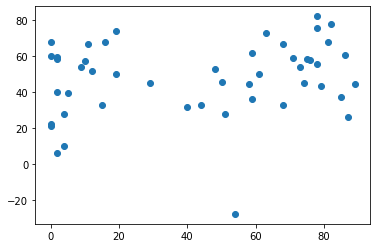

In [75]:
import matplotlib.pyplot as plt

plt.scatter(bnResty_test, bnPredict) #weird that we have that -27 inn there... hmmm